#**CASTING DEFECT PREDICTION (IMAGE CLASSIFIER)**

#### **Aim :**
Our Aim is to predict whether the Given Image is casted Correctly or Not 

**Purpose :**

Following are the Advantages
* Reduction in Quality Control Cost
* Accuracy is More
* Ability to Meet the Demands Quickly
* Time Saving Process

####**Steps :**
* Collecting the Data (Our Source from Kaggle)
  Other Sources Like 
       1. Companies Official DataBase API
       2. Cloud Sources Like Microsoft Azure (Event Hub, IOT Workspace) 
       3. Stream Analytics Pipeline includes (Databases, Apps, Messaging Systems like (Kafka), Streaming systems like (Spark Program))
* Data Preprocessing and Augumentation
* Model Selection Using Keras Tuner
* Model Building
* Deployment Phase
        1. Since its an Edge analytics project I Have been Tried to use TFLite Model for low power Availability and Processing the Model Deployment.
        2. Steps : loading tflite model into IOT Devices using Various cloud Providers Like (Microsoft Edge Analytics Platform, Google Edge Analytics and AWS IOT GreenGrass)
        3. But due to lack of availability of Resources here i going to deploy the model into a web app.  

**1.0 Collecting the Data (Kaggle Datasets)**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukilsiva","key":"b53bd3cbf685e7c10b14766f3b974bb0"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!ls ~/.kaggle

kaggle.json


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 81% 81.0M/100M [00:00<00:00, 95.1MB/s]
100% 100M/100M [00:00<00:00, 115MB/s]  


In [ ]:
!unzip /content/real-life-industrial-dataset-of-casting-product.zip

 **2.0 Data Preprocessing**

In [9]:
### Imoprting the Libraries

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Lambda
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.3.0


In [10]:
### Specifying the Size of the Images
img_width = 128
img_height = 128

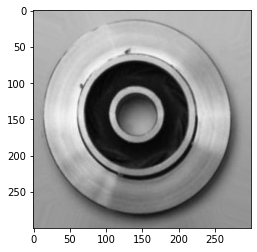

In [11]:
### Lets have a Look into the data
import cv2
from tqdm import tqdm
import os

DATADIR = "/content/casting_data/casting_data/train"

CATEGORIES = ["def_front", "ok_front"]

for category in CATEGORIES:  # do Defect and Ok Product
    path = os.path.join(DATADIR,category)  # create path to defect and ok products
    for img in os.listdir(path):  # iterate over each image per defect and ok
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [12]:
### Look at the array
print(img_array)

[[178 178 178 ... 183 182 181]
 [178 178 178 ... 183 182 181]
 [178 178 178 ... 183 182 181]
 ...
 [151 150 149 ... 144 144 144]
 [151 150 149 ... 144 144 144]
 [151 150 149 ... 144 144 144]]


In [13]:
print(img_array.shape)

(300, 300)


 So that's a 300 tall, 300 wide, and 3-channel image. 3-channel is because it's RGB (color). We definitely don't want the images that big, but also various images are different shapes, and this is also a problem.

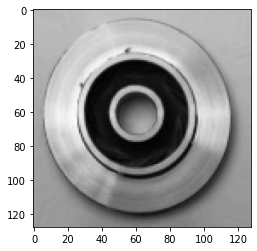

In [14]:
new_array = cv2.resize(img_array, (img_width, img_height))
plt.imshow(new_array, cmap='gray')
plt.show()

In [15]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do defect and ok

        path = os.path.join(DATADIR,category)  # create path to defect and ok
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=defect 1=ook

        for img in tqdm(os.listdir(path)):  # iterate over each image per defect and ok
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (img_width, img_height))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 2875/2875 [00:01<00:00, 1633.21it/s]


In [16]:
import random

random.shuffle(training_data)

In [17]:
X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_width, img_height, 1)

In [18]:
### Converting the Images between 0 and 1
X_train = X_train/255.0

In [ ]:
X_train = np.array(X_train)

In [20]:
X_train[0].shape

(128, 128, 1)

In [21]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_train

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [22]:
y_train.shape

(6633, 1)

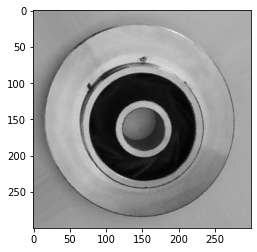

In [23]:
DATADIR = "/content/casting_data/casting_data/test"

CATEGORIES = ["def_front", "ok_front"]

for category in CATEGORIES:  # do Defect and Ok Product
    path = os.path.join(DATADIR,category)  # create path to defect and ok products
    for img in os.listdir(path):  # iterate over each image per defect and ok
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

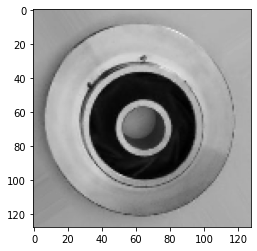

In [24]:
new_array = cv2.resize(img_array, (img_width, img_height))
plt.imshow(new_array, cmap='gray')
plt.show()

In [25]:
testing_data = []

def create_testing_data():
    for category in CATEGORIES:  # do defect and ok

        path = os.path.join(DATADIR,category)  # create path to defect and ok
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=defect 1=ook

        for img in tqdm(os.listdir(path)):  # iterate over each image per defect and ok
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (img_width, img_height))  # resize to normalize data size
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_testing_data()

100%|██████████| 262/262 [00:00<00:00, 1672.95it/s]


In [26]:
import random

random.shuffle(testing_data)

In [27]:
X_test = []
y_test = []

for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_width, img_height, 1)

In [28]:
X_test = X_test/255.0
X_test[0].shape

(128, 128, 1)

In [ ]:
X_test = np.array(X_test)

In [ ]:
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [31]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

6633 715 6633 715


In [32]:
print(type(X_train), type(X_test),type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [33]:
X_train[0].shape

(128, 128, 1)

In [34]:
y_train[0].shape

(1,)

 **3.0 Model Selection Using Keras Tuner**

In [35]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 8.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=85953b7f7dde95e2271fde948a958acd307ed0f7b0b7f64b9a368cd5d43ddded
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c9deaecd9a40a7fb80ee2504a94ed2f4f99bb43f85fd8a9ab10ed78c7cd8a883
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [36]:
### importing the Keras Tuner Library
from kerastuner import RandomSearch

In [37]:
def build_model_1(hp):  
  model = Sequential([
                      ### Input Layer
                      Conv2D(
                             filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                             kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                             activation='relu',
                             input_shape=(img_width,img_height,1)
                            ),
                      MaxPool2D(
                             pool_size=hp.Choice("pooling_1_strides", values=[2,3])
                            ),
                      Dropout(
                          rate=0.5
                            ),

                     ### Hidden Layer
                     Conv2D(
                            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                            activation='relu'
                            ),
                     MaxPool2D(
                          pool_size=hp.Choice("pooling_2_strides", values=[2,3])
                            ),
                     Dropout(
                          rate=0.5
                            ),
                      
                     ### Hidden Layer 2
                     Conv2D(
                            filters=hp.Int("Conv_3_Filter", min_value=16, max_value=32, step=16),
                            kernel_size=hp.Choice("Conv_2_Kernel", values=[3,5]),
                            activation="relu"
                           ),
                      MaxPool2D(
                          pool_size=hp.Choice("pooling_3_strides", values=[2,3])
                         ),
                      Dropout(
                          rate= 0.5
                          ),

                    ### Output Layer
                    Flatten(),
                    Dense(
                          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                          activation='relu'
                          ),
                    Dense(2, activation='sigmoid')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [38]:
### HyperParametre Tuning
tuner_search=RandomSearch(build_model_1,
                          objective='val_accuracy',
                          max_trials=5,directory='output_1',project_name="Casting_Defects")

In [39]:
tuner_search.search(X_train,y_train,epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
208/208 [==============================] - 8s 36ms/step - loss: 0.6965 - accuracy: 0.5592 - val_loss: 0.6628 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6851 - accuracy: 0.5666 - val_loss: 0.6713 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6847 - accuracy: 0.5666 - val_loss: 0.6753 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6851 - accuracy: 0.5666 - val_loss: 0.6696 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6846 - accuracy: 0.5666 - val_loss: 0.6618 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6846 - accuracy: 0.5666 - val_loss: 0.6671 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 7s 35ms/step - loss: 0.6847 - accuracy: 0.5666 - val_loss: 0.6677 - val_accuracy: 0.6336

Epoch 1/10
208/208 [==============================] - 5s 26ms/step - loss: 6.9604 - accuracy: 0.5660 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 5s 25ms/step - loss: 6.9862 - accuracy: 0.5666 - val_loss: 5.9062 - val_accuracy: 0.6336

Epoch 1/10
208/208 [==============================] - 6s 28ms/step - loss: 0.6862 - accuracy: 0.5566 - val_loss: 0.6666 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 6s 27ms/step - loss: 0.6825 - accuracy: 0.5670 - val_loss: 0.6680 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 6s 27ms/step - loss: 0.6635 - accuracy: 0.5853 - val_loss: 0.6143 - val_accuracy: 0.7175
Epoch 4/10
208/208 [==============================] - 6s 27ms/step - loss: 0.5916 - accuracy: 0.6842 - val_loss: 0.5694 - val_accuracy: 0.7273
Epoch 5/10
208/208 [==============================] - 6s 26ms/step - loss: 0.4969 - accuracy: 0.7515 - val_loss: 0.4366 - val_accuracy: 0.8713
Epoch 6/10
208/208 [==============================] - 5s 26ms/step - loss: 0.4435 - accuracy: 0.7998 - val_loss: 0.3906 - val_accuracy: 0.8573
Epoch 7/10
208/208 [==============================] - 6s 27ms/step - loss: 0.4117 - accuracy: 0.8105 - val_loss: 0.3495 - val_accuracy: 0.8853

Epoch 1/10
208/208 [==============================] - 7s 34ms/step - loss: 0.6810 - accuracy: 0.5667 - val_loss: 0.6447 - val_accuracy: 0.6797
Epoch 2/10
208/208 [==============================] - 7s 32ms/step - loss: 0.5194 - accuracy: 0.7350 - val_loss: 0.3763 - val_accuracy: 0.8629
Epoch 3/10
208/208 [==============================] - 7s 32ms/step - loss: 0.3967 - accuracy: 0.8115 - val_loss: 0.3213 - val_accuracy: 0.8685
Epoch 4/10
208/208 [==============================] - 7s 32ms/step - loss: 0.3222 - accuracy: 0.8471 - val_loss: 0.2523 - val_accuracy: 0.8867
Epoch 5/10
208/208 [==============================] - 7s 32ms/step - loss: 0.2960 - accuracy: 0.8613 - val_loss: 0.2133 - val_accuracy: 0.9105
Epoch 6/10
208/208 [==============================] - 7s 32ms/step - loss: 0.2673 - accuracy: 0.8768 - val_loss: 0.1943 - val_accuracy: 0.9552
Epoch 7/10
208/208 [==============================] - 7s 32ms/step - loss: 0.2165 - accuracy: 0.9009 - val_loss: 0.1774 - val_accuracy: 0.9413

Epoch 1/10
208/208 [==============================] - 5s 24ms/step - loss: 0.6939 - accuracy: 0.5663 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 5s 23ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336

INFO:tensorflow:Oracle triggered exit


In [50]:
model=tuner_search.get_best_models(num_models=3)[0]

In [51]:
model.add(tf.keras.Input(shape=(img_width,img_height,1)))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 96)      2496      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        55360     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2

 **4.0 Model Building**

Lets Check the Model How its performing with new Data

In [53]:
model.fit(X_train, y_train, epochs=10 ,validation_split= 0.2)

Epoch 1/10
166/166 [==============================] - 6s 36ms/step - loss: 0.1536 - accuracy: 0.9335 - val_loss: 0.0615 - val_accuracy: 0.9819
Epoch 2/10
166/166 [==============================] - 6s 33ms/step - loss: 0.1283 - accuracy: 0.9476 - val_loss: 0.0543 - val_accuracy: 0.9872
Epoch 3/10
166/166 [==============================] - 6s 33ms/step - loss: 0.1289 - accuracy: 0.9433 - val_loss: 0.0752 - val_accuracy: 0.9925
Epoch 4/10
166/166 [==============================] - 6s 33ms/step - loss: 0.1301 - accuracy: 0.9463 - val_loss: 0.0590 - val_accuracy: 0.9857
Epoch 5/10
166/166 [==============================] - 6s 33ms/step - loss: 0.1192 - accuracy: 0.9514 - val_loss: 0.2121 - val_accuracy: 0.9141
Epoch 6/10
166/166 [==============================] - 6s 33ms/step - loss: 0.1182 - accuracy: 0.9534 - val_loss: 0.0398 - val_accuracy: 0.9977
Epoch 7/10
166/166 [==============================] - 6s 33ms/step - loss: 0.0895 - accuracy: 0.9649 - val_loss: 0.0686 - val_accuracy: 0.9819

In [54]:
def predictions(image):
  ### Loading the Image
  test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  test_image = cv2.resize(test_image,(img_width, img_height))
  plt.imshow(test_image, cmap="gray") # Plot Image
  test_image= np.array(test_image).reshape(-1, img_width, img_height, 1)
  test_image = test_image/255.0
  test_image = np.array(test_image)

  ###Predictions
  results = model.predict(test_image)
  results = np.argmax(results, axis=1)
  if results[0] == 1:
    predictions = 'OK Product'
  else:
    predictions = 'Defect Product'

  return results[0], ("Predictions :",predictions)

Enter the Image To be Predicted:/content/casting_data/casting_data/test/ok_front/cast_ok_0_10.jpeg


(1, ('Predictions :', 'OK Product'))

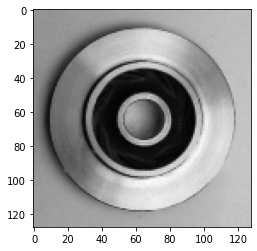

In [55]:
img = input("Enter the Image To be Predicted:")
predictions(img)

OK to identify the correct one

Enter the Image To be Predicted:/content/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg


(0, ('Predictions :', 'Defect Product'))

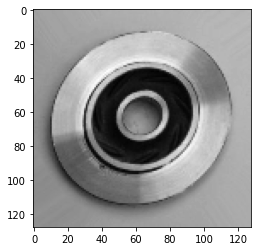

In [56]:
img = input("Enter the Image To be Predicted:")
predictions(img)

!!! Works fine to identify Defects Too

**5.0 Model Deployment**

since its an edge of the device deployment(Industrial Quality Checking Vision Cameras)

* Since the edge devices has not that much sophosticated Memory, CPU and Processing Devices we need to optimise the Model.
* So here we are Going to do Post Model Quantization using tflite

In [57]:
### Converting to light weight Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpg9t3xpb_/assets


In [58]:
### Lets Optimize the current Model
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]  # This steps will optimize the Weights of the model from float. By Default its Float 32
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
#Converter.representative_dataset = training_data          
tflite_Quantized_Model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpo4blfkeg/assets


INFO:tensorflow:Assets written to: /tmp/tmpo4blfkeg/assets


In [59]:
### Deploying the tflite model
interpreter = tf.lite.Interpreter(model_content = tflite_model) ### Loading Quantized model act we can do with tflite_Quantized_model too
interpreter.allocate_tensors()
input_tensor_index = interpreter.get_input_details()[0]["index"]
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

In [60]:
interpreter.get_tensor_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'conv2d_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 128, 128,   1], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   1], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'sequential/conv2d/BiasAdd/ReadVariableOp/resource',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([96], dtype=int32),
  'shape_signature': array([96], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 2,
  'name': 'sequential/conv2d_1/BiasAdd/ReadVariableOp/resource',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_po

In [78]:
def tflite_model_predictions(image):
  ### Loading the Image
  test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  test_image = cv2.resize(test_image,(img_width, img_height))
  plt.imshow(test_image, cmap="gray") # Plot Image
  test_image= np.array(test_image).reshape(-1, img_width, img_height, 1)
  test_image = test_image/255.0
  test_image = np.array(test_image)
  test_image = np.asarray(test_image, dtype=np.float32)
  
  ### Starting the interpretor
  interpreter.set_tensor(input_tensor_index, test_image)
  interpreter.invoke()


  ###Predictions
  results = np.argmax(output()[0])
  if results == 1:
    predictions = 'OK Product'
  else:
    predictions = 'Defect Product'  
    
  return results, ("Predictions :",predictions)

Enter the Image To be Predicted:/content/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg


(0, ('Predictions :', 'Defect Product'))

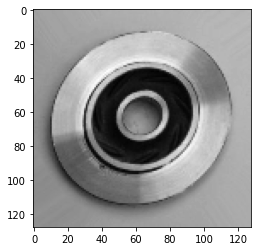

In [79]:
img = input("Enter the Image To be Predicted:")
tflite_model_predictions(img)

!!! This to Works Good lets Compare the time taken by both the Models

In [83]:
import time

def tflite_model_predictions_time(image):
  start_time = time.time()
  ### Loading the Image
  test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  test_image = cv2.resize(test_image,(img_width, img_height))
  test_image= np.array(test_image).reshape(-1, img_width, img_height, 1)
  test_image = test_image/255.0
  test_image = np.array(test_image)
  test_image = np.asarray(test_image, dtype=np.float32)
  
  ### Starting the interpretor
  interpreter.set_tensor(input_tensor_index, test_image)
  interpreter.invoke()

  return ("The time taken by lite model is %s Seconds" %(str(time.time() - (start_time))))

In [84]:
img = input("Enter the Image To be Predicted:")
tflite_model_predictions_time(img)

Enter the Image To be Predicted:/content/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg


'The time taken by lite model is 0.011669158935546875 Seconds'

In [85]:
def predictions_time(image):
  start_time = time.time()
  ### Loading the Image
  test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  test_image = cv2.resize(test_image,(img_width, img_height))
  test_image= np.array(test_image).reshape(-1, img_width, img_height, 1)
  test_image = test_image/255.0
  test_image = np.array(test_image)

  ###Predictions
  results = model.predict(test_image)
  results = np.argmax(results, axis=1)

  return ("The time taken by tf actual model is %s Seconds" %(str(time.time() - (start_time))))

In [86]:
img = input("Enter the Image To be Predicted:")
predictions_time(img)

Enter the Image To be Predicted:/content/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg


'The time taken by tf actual model is 0.04103875160217285 Seconds'

* Clearly shows that tflite Model is Faster and Compatible than actual Model
* Quantized Model is More Better than this model but there will 0.001 accuracy drop when larger dataset comes in but thats not a Big Deal in Edge Computing
* Due to my education Purpose i havent proceed further but we can proceed further in Real World Machines, android apps, Apple apps like that via lots of sources like (Cloud IOT Devices) or Creating a Setup file for deploying in edge Devices